### SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [1]:
import numpy as np
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import mikeio


num_sensors = 3 
lags = 52

sensor_locations = np.array([2849,   41, 2452])
np.save("Data/sensor_locations.npy",sensor_locations)


In [2]:
ds = mikeio.read("Data/Area.dfsu",time=slice("2022-01-01", "2022-04-30"), items=[0])
ds.to_dfs("Data/Area_5m.dfsu")

In [3]:
load_X = ds[0].to_numpy()
load_X.shape

(5760, 3320)

In [4]:
n = load_X.shape[0]
m = load_X.shape[1]
# sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
sensor_locations


array([2849,   41, 2452])

We now select indices to divide the data into training, validation, and test sets.

In [5]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

In [6]:
# FRTP: Question: Isn't the test and training data overlapping? Only the start data point is varying, but the lagged sequence has been seen before?? 

In [7]:
# FRTP:
n_test = 174
n_valid = 174
n_train = 1000

train_indices = np.arange(0, n_train)
valid_test_indices = np.arange(n_train,n_train+n_valid)
test_indices = np.arange(n_train+n_valid,n_train+n_valid+n_test)


sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [17]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

We now organize the data such that the inputs are of shape (batch_size, lags, num_sensors) with corresponding outputs of size (batch_size, state_dimension).

In [18]:
### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

We train the model using the training and validation datasets.

In [19]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.3914)
Training epoch 20
Error tensor(0.0726)
Training epoch 40
Error tensor(0.0487)
Training epoch 60
Error tensor(0.0471)
Training epoch 80
Error tensor(0.0438)
Training epoch 100
Error tensor(0.0513)
Training epoch 120
Error tensor(0.0426)
Training epoch 140
Error tensor(0.0436)
Training epoch 160
Error tensor(0.0433)
Training epoch 180
Error tensor(0.0397)
Training epoch 200
Error tensor(0.0446)
Training epoch 220
Error tensor(0.0403)
Training epoch 240
Error tensor(0.0399)
Training epoch 260
Error tensor(0.0471)
Training epoch 280
Error tensor(0.0460)


Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [20]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print('Test Reconstruction Error: ')
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

Test Reconstruction Error: 
0.09041482


In [ ]:
# Default from paper ?!?!?!
# Test Reconstruction Error: 
# 0.0193155

# When train and test are clearly separated:
# Test Reconstruction Error: 
# 0.04866559

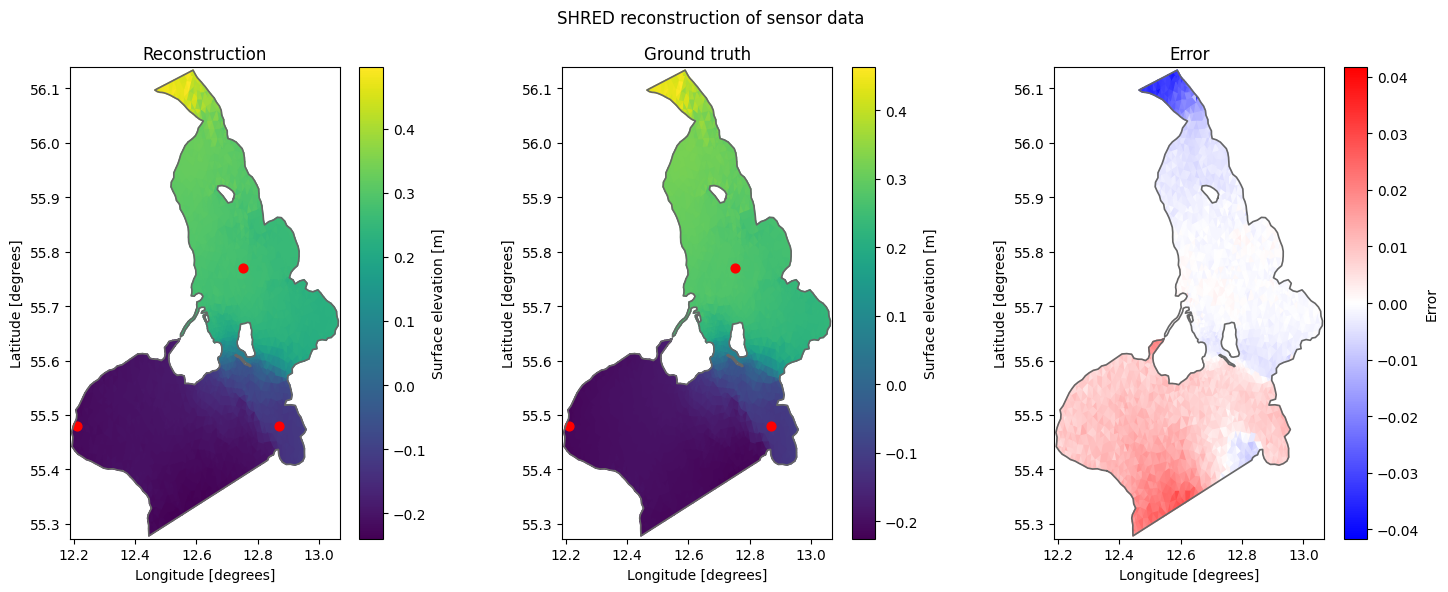

In [94]:
elem_cor = ds[0].geometry.element_coordinates
plot_index = 10


# Create dataarrays for plotting
da_plot_recon = ds[0].sel(time=ds.time[test_indices[plot_index]+ lags - 1]).copy()
da_plot_true = da_plot_recon.copy()
da_plot_err = da_plot_recon.copy()
# Fill with values from the reconstruction and the ground truth, as well as errors
da_plot_recon.values = test_recons[plot_index]
da_plot_true.values = test_ground_truth[plot_index]
da_plot_err.values =  test_ground_truth[plot_index]-test_recons[plot_index]
# min and max values for the colorbar
vmin = -max(abs(np.min(da_plot_err.values)),abs(np.max(da_plot_err.values)))
vmax = max(abs(np.min(da_plot_err.values)),abs(np.max(da_plot_err.values)))

fig,axs = plt.subplots(1,3,figsize=(15,6))
fig.suptitle('SHRED reconstruction of sensor data')

da_plot_true.plot(ax = axs[1],add_colorbar=False)
cbar = fig.colorbar(axs[1].collections[0], ax=axs[1],label='Surface elevation [m]')
axs[1].set_title('Ground truth')

da_plot_err.plot(ax = axs[2],cmap="bwr",vmin=vmin,vmax=vmax,add_colorbar=False)
cbar = fig.colorbar(axs[2].collections[0], ax=axs[2],label='Error')
axs[2].set_title('Error')

da_plot_recon.plot(ax = axs[0],add_colorbar=False)
cbar = fig.colorbar(axs[0].collections[0], ax=axs[0],label='Surface elevation [m]')
axs[0].set_title('Reconstruction')

# Add a red dot to the spatial points indicated by the sensor locations
for i in range(num_sensors):
    axs[0].scatter(elem_cor[sensor_locations[i],0], elem_cor[sensor_locations[i],1], color='red', s=40, label='Sensor location')
    axs[1].scatter(elem_cor[sensor_locations[i],0], elem_cor[sensor_locations[i],1], color='red', s=40, label='Sensor location')

plt.tight_layout()



In [95]:
rmspe = np.sqrt(np.mean(np.square((da_plot_err.values / da_plot_true.values)), axis=0))
rmse = np.sqrt(np.mean(np.square((da_plot_err.values)), axis=0))

print('RMSPE: ', rmspe,' \nRMSE:  ', rmse)

RMSPE:  0.063487746  
RMSE:   0.009402187


# Forecast plots

In [7]:
recon = np.load('ForecastingResults/reconstructions.npy')

In [8]:
recon.shape

(792, 3320)